%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install evaluate

In [ ]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='latin-1')
data = data[:3000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style','URL':'description'})
data = data[['image','author']]
data['image'] = [f'.{x}' for x in data['image']]
print(f'columns:{[x for x in data.columns]}')

columns:['image', 'author']


In [ ]:
labels_auth = data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [ ]:
data['author'] = data['author'].map(label2id_auth)
data.columns

Index(['image', 'author'], dtype='object')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 3000/3000 [00:36<00:00, 82.72it/s]


In [ ]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.4744, 0.4149, 0.3598])
Std of the image: tensor([0.1894, 0.1900, 0.1915])


In [ ]:
# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(data['image'],data['author'], test_size=0.2, random_state=42)

In [12]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None,):
        self.data = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        author = torch.tensor(self.labels[index])
        return(img_pil,author)
    
train_dataset = ArtDataset(X_train.values,y_train.values,transform=train_transform)
val_dataset = ArtDataset(X_val.values,y_val.values,transform=test_transform)

/var/tmp/ipykernel_5282/1364352914.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


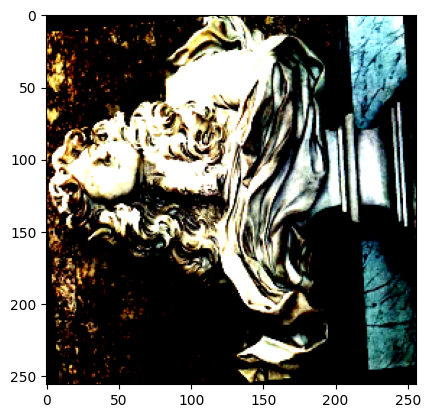

Author: 364


In [13]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img.T)
plt.show()
print(f"Author: {label}")

In [ ]:
#CNN

class ArtCNN(nn.Module):
    
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3)
        self.maxpool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(32,64,3)
        self.maxpool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(64,64,3)
        self.maxpool4 = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(64,64,3)
        self.maxpool5 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*25*25,512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        #x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        #x = self.maxpool4(x)
        x = self.maxpool5(self.conv5(x))

        x = x.reshape(x.size(0),-1)

        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu1(x)
        x = self.fc3(x)
        return x

net = ArtCNN(len(labels_auth)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-6, momentum=0.9)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_values, title="Loss Plot"):
    """
    Plot the loss values over training epochs.

    Parameters:
    - loss_values: A list or array of loss values for each epoch.
    - title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [ ]:
train_losses = []
with tqdm(total=700) as pbar:
    for epoch in range(700):
        running_loss= 0.0
        for i, data in enumerate(trainloader,0):
            inputs, labels = data[0].to(device),data[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        pbar.set_description(f'loss: {running_loss / 100:.3f}')
        train_losses.append(running_loss/100)
        pbar.update(1)
print('Finished Training')

In [ ]:
plot_loss(train_losses, "Training Loss")

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataiter = iter(testloader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels_auth[labels[j]] for j in range(4)))


In [ ]:
net.eval()
images = images.to(device)
outputs = net(images).to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % labels_auth[predicted[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
test_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images).to(device)
        loss = criterion(outputs,labels)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(loss.item())
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
plot_loss(test_loss,"Test Loss")